In [1]:
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

from scipy import stats
from scipy.stats import norm, skew 
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 

In [123]:
train_df = pd.read_csv('./1-train-preprocess-outlier-nan.csv',header=0)
train_df.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,SalePrice
0,856,854,0,None,3,1Fam,TA,No,706.000,0.000,...,0,Pave,8,856.000,AllPub,0,2003,2003,2008,208500.000
1,1262,0,0,None,3,1Fam,TA,Gd,978.000,0.000,...,0,Pave,6,1262.000,AllPub,298,1976,1976,2007,181500.000
2,920,866,0,None,3,1Fam,TA,Mn,486.000,0.000,...,0,Pave,6,920.000,AllPub,0,2001,2002,2008,223500.000
3,961,756,0,None,3,1Fam,Gd,No,216.000,0.000,...,0,Pave,7,756.000,AllPub,0,1915,1970,2006,140000.000
4,1145,1053,0,None,4,1Fam,TA,Av,655.000,0.000,...,0,Pave,9,1145.000,AllPub,192,2000,2000,2008,250000.000


In [124]:
test_df = pd.read_csv('./1-test-preprocess-outlier-nan.csv',header=0)
test_df.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,896,0,0,None,2,1Fam,TA,No,468.000,144.000,...,WD,120,Pave,5,882.000,AllPub,140,1961,1961,2010
1,1329,0,0,None,3,1Fam,TA,No,923.000,0.000,...,WD,0,Pave,6,1329.000,AllPub,393,1958,1958,2010
2,928,701,0,None,3,1Fam,TA,No,791.000,0.000,...,WD,0,Pave,6,928.000,AllPub,212,1997,1998,2010
3,926,678,0,None,3,1Fam,TA,No,602.000,0.000,...,WD,0,Pave,7,926.000,AllPub,360,1998,1998,2010
4,1280,0,0,None,2,TwnhsE,TA,No,263.000,0.000,...,WD,144,Pave,5,1280.000,AllPub,0,1992,1992,2010


## 目标值处理

线性的模型需要正态分布的目标值才能发挥最大的作用。我们需要检测房价什么时候偏离正态分布。使用probplot函数，即正态概率图


 mu = 180932.92 and sigma = 79467.79



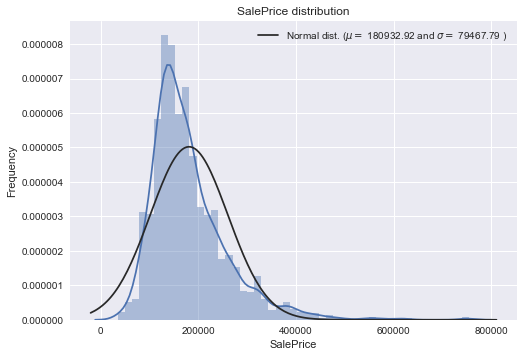

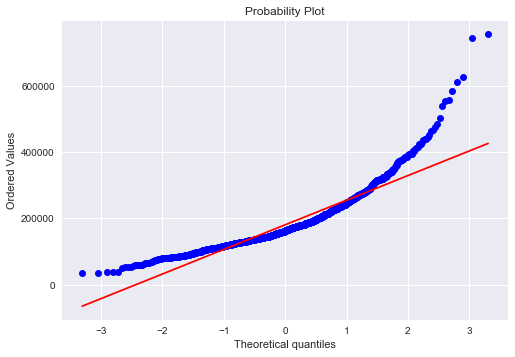

In [125]:
sns.distplot(train_df.SalePrice , fit=norm)

(mu, sigma) = norm.fit(train_df.SalePrice)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train_df.SalePrice, plot=plt)
plt.show()

此时的正态分布属于右偏态分布，即整体峰值向左偏离，并且偏度(skewness)较大，需要对目标值做log转换，以恢复目标值的正态性。


 mu = 12.02 and sigma = 0.40



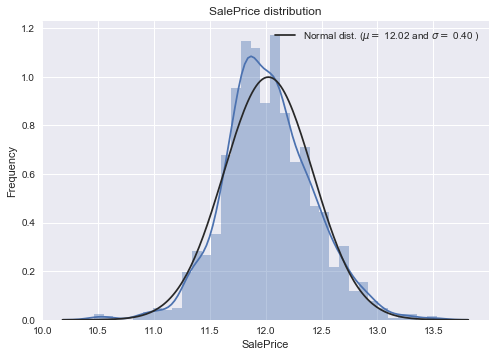

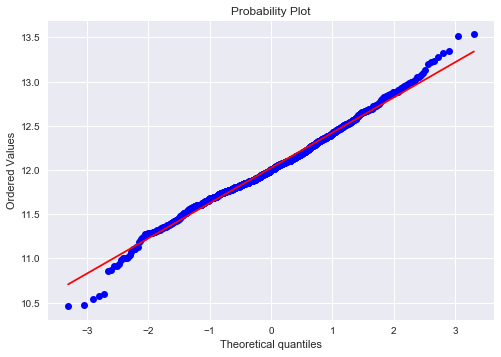

In [126]:
train_df.SalePrice = np.log1p(train_df.SalePrice)

sns.distplot(train_df.SalePrice , fit=norm);

(mu, sigma) = norm.fit(train_df.SalePrice)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train_df.SalePrice, plot=plt)
plt.show()

对年代进行处理
生成建造年龄，装修年龄，花园的修建年龄
生成总面积
查看数值型变量的分布，改变成正态分布
直接进行哑变量变换

In [127]:
train = train_df.copy()
test = test_df.copy()
ntrain = train.shape[0]
ntest = test.shape[0]
all_data = pd.concat((train,test)).reset_index(drop=True)
y_train = all_data[:ntrain]['SalePrice']
all_data = all_data.drop(['SalePrice'],axis=1)
all_data.shape

(2917, 80)

## 剔除特征

Utilities的取值只有一个样本是NoSeWa，并且是在训练集，其他取值都是AllPub，该特征列剔除对模型的结果影响很小。

In [128]:
all_data.Utilities.value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

In [129]:
all_data[all_data.Utilities=='NoSeWa']

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
943,1344,0,0,None,3,1Fam,TA,No,111.000,354.000,...,COD,233,Pave,7,819.000,NoSeWa,0,1958,1958,2009


In [130]:
all_data = all_data.drop(['Utilities'],axis=1)

## 构建特征

将YearBuilt、YearRemodAdd、GarageYrBlt列分别减去YrSold，构造出三个距离卖出时的时长特征。

In [131]:
all_data['BuiltDur'] = all_data.YrSold - all_data.YearBuilt
all_data['RemodDur'] = all_data.YrSold - all_data.YearRemodAdd
all_data['GarageBltDur'] = all_data.YrSold - all_data.GarageYrBlt
all_data.drop(['YearBuilt','YearRemodAdd','GarageYrBlt'],axis=1,inplace=True)

因为我们实际在购买房子的时候会考虑总面积的大小，但是此数据集中并没有包含此数据。总面积等于地下室面积+1层面积+2层面积。

In [132]:
all_data['TotalSF'] = all_data.TotalBsmtSF + all_data['1stFlrSF'] + all_data['2ndFlrSF']

## 特征处理

MSSubClass表示的是类别，但是给出来的是数字,需要将其转化为类别型变量。

In [133]:
all_data.MSSubClass = all_data.MSSubClass.astype('category',categories=all_data.MSSubClass.unique())    

我们对房价进行分析，不符合正态分布的我们将其log转换，使其符合正态分布。那么偏离正态分布太多的特征我们也对它进行转化，这里取abs(skew)值大于0.75

In [134]:
numerical_cols = all_data.select_dtypes(exclude=['category']).columns.values
skewness_cols = all_data[numerical_cols].skew().sort_values(ascending=False)
skewness_cols = skewness_cols[abs(skewness_cols) > 0.75].index
from scipy.special import boxcox1p
lam = 0.15
for col in skewness_cols:
    all_data[col] = boxcox1p(all_data[col], lam)

由于出售年代和月份都是有限的值，可以作为类别型变量来处理

In [135]:
all_data.YrSold.unique()

array([2008, 2007, 2006, 2009, 2010], dtype=int64)

In [136]:
all_data.MoSold.unique()

array([ 2,  5,  9, 12, 10,  8, 11,  4,  1,  7,  3,  6], dtype=int64)

In [137]:
for col in ('YrSold','MoSold'):
    all_data[col] = all_data[col].astype('category',categories=all_data[col].unique())

对有序的类别型特征，进行LabelEncode。

In [138]:
label_cols = ['BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
             'BsmtQual','CentralAir','Electrical','ExterCond','ExterQual',
             'Fence','FireplaceQu','GarageCond','GarageFinish','GarageQual',
             'HeatingQC','KitchenQual','LandContour','LandSlope','LotShape',
             'PavedDrive','PoolQC','Alley','Street']

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in label_cols:
    all_data[col] = le.fit_transform(all_data[col])
      
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 80)


对无序的类别型特征，进行哑变量变换

In [139]:
all_data = pd.get_dummies(all_data)
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 250)


目前为止，特征处理完毕，输出到文件

In [147]:
train = all_data[:ntrain].join(y_train)
test = all_data[ntrain:]
train.to_csv('./2-train-feature-engineering.csv',index=False)
test.to_csv('./2-test-feature-engineering.csv',index=False)